In [279]:
from gurobipy import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

tests_per_week = 2
number_of_people = 20

availability_matrix = np.random.randint(0,2, size=(number_of_people, 7*number_of_people)) # random availabilities
# availability_matrix = np.ones((number_of_people, 7*number_of_people)) # pretend everyone is available, always

# Zero out irrelevant parts of the matrix
for i in range(len(availability_matrix)):
    if i > 0:
        for j in range(i*7):
            availability_matrix[i][j] = 0
    if i < len(availability_matrix):
        for j in range((i+1)*7, 7*number_of_people):
            availability_matrix[i][j] = 0
            
# Dealing with infeasibles...
people_total_availability = np.sum(availability_matrix, 1)
infeasible_people = np.where(people_total_availability < tests_per_week)

# Enforce that everyone gets two tests a week
Aeq = availability_matrix
beq = np.multiply(tests_per_week, np.ones((number_of_people,1)))

# Loosen beq in the case where people aren't available enough
for i in range(len(infeasible_people[0])):
    beq[infeasible_people[0][i]][0] = people_total_availability[infeasible_people[0][i]]

# This picks up the number of total tests (per?) person each day of the week
testing_capacity_matrix = np.zeros((7, 7*number_of_people))
for i in range(len(testing_capacity_matrix)):
    for j in range(i, 7*number_of_people, 7):
        testing_capacity_matrix[i][j] = 1
        
A = testing_capacity_matrix
b = np.ceil(np.multiply(number_of_people*tests_per_week/7, np.ones((7,1)))) # why is this ceil? why o

# x is all zeros except for the 1 schedule choice per-person ??

# Gurobi optimization, still a little confused here.
m = Model()

# Variables
x0 = m.addVars(7*number_of_people, name='x0', vtype=GRB.BINARY) # x \in [0,1]

m.setObjective(x0.sum(), GRB.MAXIMIZE) # is maximize right? we want people to take as many tests as poss.

# Ax <= b
for i in range(7):
    m.addConstr(sum(x0[j]*A[i][j] for j in range(7*number_of_people)) <= b[i][0])

# Aeq x = beq
for i in range(number_of_people):
    m.addConstr(sum((x0[j]) for j in range(7*i, 7*(i+1))) == beq[i][0])

m.optimize()

print()
for i in range(number_of_people):
    idx = 7*i
    num_tests = 0
    days_avail = 0
    for j in range(7):
        num_tests += x0[idx].x
        days_avail += Aeq[i][idx]
        idx += 1
    if (days_avail < num_tests):
        print("!!! Person %02d: available days = %d --> %d tests !!!" % (i, days_avail, num_tests))
    else:
        print("Person %02d: available days = %d --> %d tests" % (i, days_avail, num_tests))

print()
for i in range(7):
    tests = 0
    for j in range(i, 7*number_of_people, 7):
        tests += x0[j].x
    print("On day %d, %d tests" % (i, tests))

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (mac64)
Optimize a model with 27 rows, 140 columns and 280 nonzeros
Model fingerprint: 0x2c4f9054
Variable types: 0 continuous, 140 integer (140 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+00]
Found heuristic solution: objective 36.0000000
Presolve time: 0.00s
Presolved: 27 rows, 140 columns, 280 nonzeros
Variable types: 0 continuous, 140 integer (140 binary)

Explored 0 nodes (0 simplex iterations) in 0.05 seconds
Thread count was 4 (of 4 available processors)

Solution count 1: 36 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.600000000000e+01, best bound 3.600000000000e+01, gap 0.0000%

Person 00: available days = 3 --> 2 tests
Person 01: available days = 1 --> 1 tests
Person 02: available days = 2 --> 2 tests
Person 03: available days = 3 --> 2 tests
Person 04: available days = 5 --> 2 tests
Person 05:

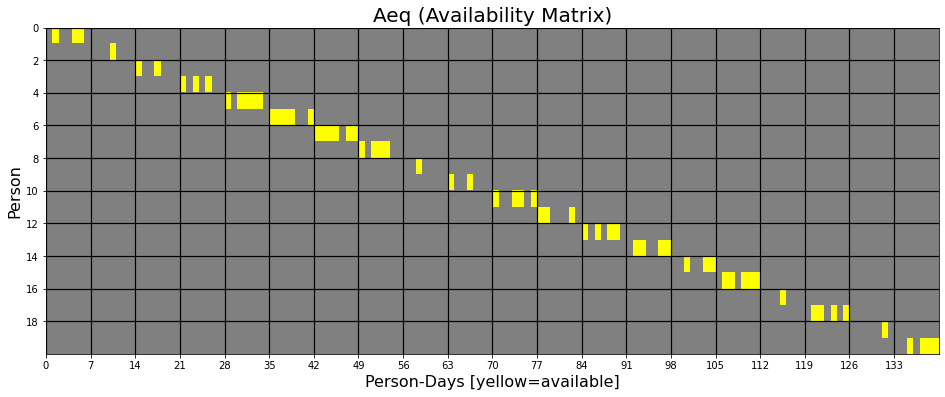

In [280]:
# Display Aeq
fig, ax = plt.subplots(figsize=(16,6))
cmap = colors.ListedColormap(['gray', 'yellow'])

ax.imshow(Aeq, cmap=cmap, aspect='auto', extent=[0, 7*number_of_people, number_of_people, 0])
ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=1.2)

ax.set_xticks(np.arange(0, 7*number_of_people, 7))
ax.set_yticks(np.arange(0, number_of_people, 2))
ax.set_ylabel("Person", fontsize=16)
ax.set_xlabel("Person-Days [yellow=available]", fontsize=16)
ax.set_title("Aeq (Availability Matrix)", fontsize=20)

plt.savefig("Aeq.png")
plt.show()
plt.close()

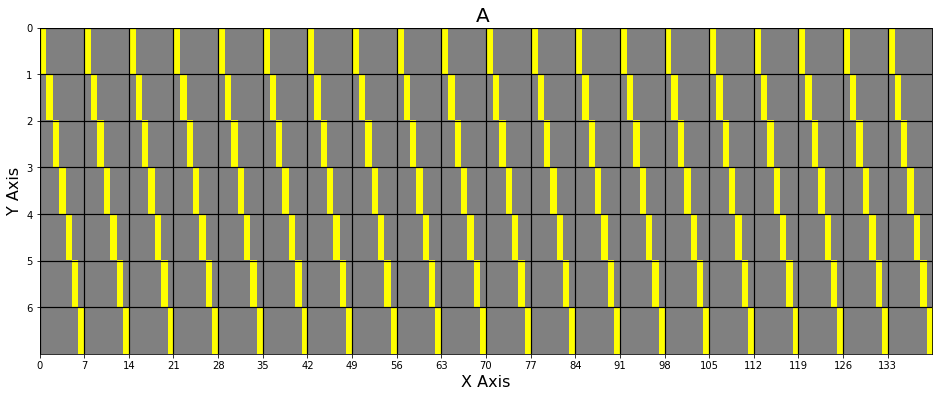

In [281]:
# Display A
fig, ax = plt.subplots(figsize=(16,6))
cmap = colors.ListedColormap(['gray', 'yellow'])

ax.imshow(A, cmap=cmap, aspect='auto', extent=[0, 7*number_of_people, 7, 0])
ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=1.2)

ax.set_xticks(np.arange(0, 7*number_of_people, 7))
ax.set_yticks(np.arange(0, 7, 1))
ax.set_ylabel("Y Axis", fontsize=16)
ax.set_xlabel("X Axis", fontsize=16)
ax.set_title("A ", fontsize=20)

plt.savefig("A.png")
plt.show()
plt.close()

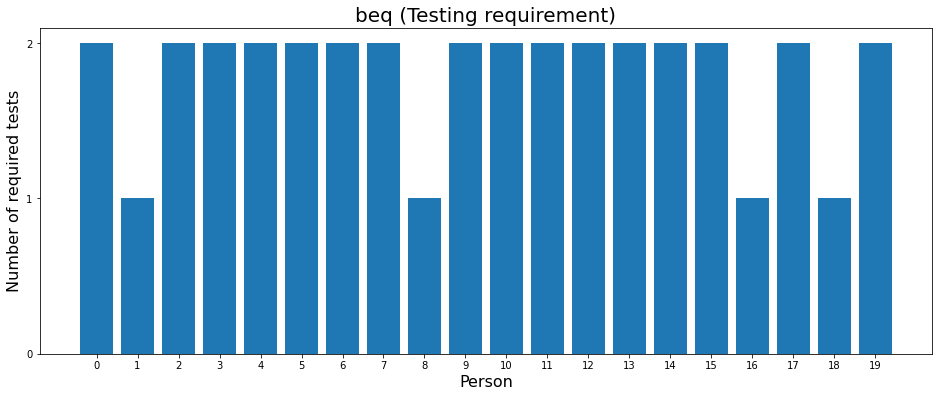

In [282]:
# Display beq
fig, ax = plt.subplots(figsize=(16,6))
cmap = colors.ListedColormap(['gray', 'yellow'])

# Turn beq numpy array to a flat list of beq values
beq_list = [item for sublist in beq.tolist() for item in sublist]

ax.bar(range(number_of_people), height=beq_list)
ax.set_yticks(range(0, int(max(beq_list)) + 1, 1))
ax.set_xticks(range(number_of_people))

ax.set_ylabel("Number of required tests", fontsize=16)
ax.set_xlabel("Person", fontsize=16)
ax.set_title("beq (Testing requirement)", fontsize=20)

plt.savefig("beq.png")
plt.show()
plt.close()

In [197]:
beq

array([[2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [1.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.]])